# MHKiT NDBC Metocean Data

Metocean data is a useful addition to wave and current ocean data for the design for offshore structures, including wave energy converters (WECs). Metocean data primarily includes information pertaining to the wind, wave, and climate conditions on the ocean surface at a given location.

MHKiT includes functions to request and manipulate metocean data from the National Data Buoy Center, including spectral wave density, standard meteorological data and continuous wind speed. As a demonstration, this notebook will walk through the following steps to find the wind speeds at a given location.

 1. Request Continous Wind Data from NDBC
 2. Visualize wind data for specific dates
 
     - Calculate and plot the hourly mean wind speeds for a given date
     - Plot a wind rose of the continuous speeds for a given date
     - Plot the joint PDF of wind gusts for a given date

We will start by importing the necessary python packages (`pandas`, `numpy`, `matplotlib`), and MHKiT submodules (`wave.io.ndbc`, `tidal.graphics`).

In [1]:
from mhkit.wave.io import ndbc
from mhkit.tidal.graphics import plot_rose 
from mhkit.tidal.graphics import plot_joint_probability_distribution
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Request Continuous Wind Data from NDBC
   
MHKiT can be used to request historical data from the National Data Buoy Center ([NDBC](https://www.ndbc.noaa.gov/)). This process is split into the following steps:

- Query available NDBC data  
- Select years of interest 
- Request Data from NDBC
- Convert the DataFrames to DateTime Index
 

### Query available NDBC data  
Looking at the help for the `ndbc.available_data` function (`help(ndbc.available_data)`) the function requires a parameter to be specified and optionally the user may provide a station ID as a string. A full list of available historical parameters can be found [here](https://www.ndbc.noaa.gov/data/historical/) although only some of these are currently supported.  We are interested in historical continuous wind data `'cwind'`. Additionally, we will specify the buoy number as `'46022'` to only return data associated with this site.

In [2]:
# Specify the parameter as continuous wind speeds and the buoy number to be 46022
parameter = 'cwind'
buoy_number = '46022' 
ndbc_available_data = ndbc.available_data(parameter, buoy_number)
ndbc_available_data

,id,year,filename
1209,46022,1996,46022c1996.txt.gz
1210,46022,1997,46022c1997.txt.gz
1211,46022,1998,46022c1998.txt.gz
1212,46022,1999,46022c1999.txt.gz
1213,46022,2000,46022c2000.txt.gz
1214,46022,2001,46022c2001.txt.gz
1215,46022,2002,46022c2002.txt.gz
1216,46022,2003,46022c2003.txt.gz
1217,46022,2004,46022c2004.txt.gz
1218,46022,2005,46022c2005.txt.gz


### Select years of interest

The `ndbc.available_data` function has returned a DataFrame with columns 'id', 'year', and 'filename'. The year column is of type int while the filename and id (5 digit alpha-numeric specifier) are of type string. In this case, the years returned from `ndbc_available_data` span  1996 to the last year the buoy was operational (currently 2018 for 46022 wind data). For demonstration, we have decided we are interested in the data from 2018, so we will create a new `years_of_interest` DataFrame which only contains the year 2018.

In [3]:
# Slice the available data to only include 2018 and more recent
years_of_interest = ndbc_available_data[ndbc_available_data.year == 2018]
years_of_interest.head()


,id,year,filename
1231,46022,2018,46022c2018.txt.gz


### Request Data from NDBC

The filename column in our `years_of_interest` DataFrame and the parameter is needed to request the data. To get the data we can use the `ndbc.request_data` function for each buoy id and year in the passed DataFrame. This function will return the parameter data as a dictionary of DataFrames which may be accessed by buoy id and then the year for multiple buoys or just the year for a single buoy. 

In [4]:
# Get dictionary of parameter data by year
filenames = years_of_interest['filename']
ndbc_requested_data = ndbc.request_data(parameter, filenames)
ndbc_requested_data

{'2018':         #YY  MM  DD  hh  mm  WDIR  WSPD  GDR   GST  GTIME
 0      2017  12  31  23   0   206   7.8  999  99.0   9999
 1      2017  12  31  23  10   202   8.3  999  99.0   9999
 2      2017  12  31  23  20   199   8.2  999  99.0   9999
 3      2017  12  31  23  30   194   7.6  999  99.0   9999
 4      2017  12  31  23  40   188   6.6  999  99.0   9999
 ...     ...  ..  ..  ..  ..   ...   ...  ...   ...    ...
 18319  2018   5   8  16  10   107   0.9  999  99.0   9999
 18320  2018   5   8  16  20   210   0.3  999  99.0   9999
 18321  2018   5   8  16  30   271   1.1  999  99.0   9999
 18322  2018   5   8  16  40   275   1.4  999  99.0   9999
 18323  2018   5   8  16  50   277   1.4  281   2.4   1642
 
 [18324 rows x 10 columns]}

### Convert the DataFrames to DateTime Index

The data returned for each year has a variable number of columns for the year, month, day, hour, minute, and the way the columns are formatted (this is a primary reason for return a dictionary of DataFrames indexed by years). A common step a user will want to take is to remove the inconsistent NDBC date/ time columns and create a standard DateTime index. The MHKiT function `ndbc.to_datetime_index` will perform this standardization by parsing the NDBC date/ time columns into DateTime format and setting this as the DataFrame Index and removing the NDBC date/ time columns. This function operates on a DateFrame therefore we will iterate over each year of the `ndbc_requested_data` dictionary.

In [5]:
# Convert the header dates to a Datetime Index and remove NOAA date columns for each year
ndbc_data = {}
year = '2018'
year_data = ndbc_requested_data[year]
ndbc_data[year] = ndbc.to_datetime_index(parameter, year_data)

# Display DataFrame of 46022 data from 2018
ndbc_data['2018']

,WDIR,WSPD,GDR,GST,GTIME
date,,,,,
2017-12-31 23:00:00,206,7.8,999,99.0,9999
2017-12-31 23:10:00,202,8.3,999,99.0,9999
2017-12-31 23:20:00,199,8.2,999,99.0,9999
2017-12-31 23:30:00,194,7.6,999,99.0,9999
2017-12-31 23:40:00,188,6.6,999,99.0,9999
...,...,...,...,...,...
2018-05-08 16:10:00,107,0.9,999,99.0,9999
2018-05-08 16:20:00,210,0.3,999,99.0,9999
2018-05-08 16:30:00,271,1.1,999,99.0,9999


## 2. Visualize wind data for specific dates

Wind conditions may be characterized by average wind speed and direction or gust speed and direction. A time series of hourly mean wind speeds, wind rose, or joint probability density function are useful tools to visualize this information. Using the historical 10-minute continuous wind data from NDBC, we can calculate these variables using MHKiT.

### Plot the hourly mean wind speeds on January 11, 2018

In [6]:
# Display DataFrame of 46022 data from January 11, 2018
daily_data = ndbc_data['2018']['2018-01-11']
daily_data

,WDIR,WSPD,GDR,GST,GTIME
date,,,,,
2018-01-11 00:00:00,199,6.6,999,99.0,9999
2018-01-11 00:10:00,197,6.6,999,99.0,9999
2018-01-11 00:20:00,196,6.1,999,99.0,9999
2018-01-11 00:30:00,194,6.1,999,99.0,9999
2018-01-11 00:40:00,186,6.3,999,99.0,9999
...,...,...,...,...,...
2018-01-11 23:10:00,186,10.2,999,99.0,9999
2018-01-11 23:20:00,192,9.4,999,99.0,9999
2018-01-11 23:30:00,191,9.2,999,99.0,9999


The data for January 11, 2018 is given in 10 minute intervals. We can consider the average hourly wind speed to cover the 30 minute periods before and after each hour. For example, the mean speed at 2:00 averages all speeds between 1:30-2:30.

In [7]:
# Get average hourly wind speeds
hours = np.arange(1,24,1)
hourly_mean_speeds = []
for hour in hours:
    # Create a boolean mask using the start and end times
    start_time = '2018-01-11 ' + str(hour-1) + ':30:00'
    end_time = '2018-01-11 ' + str(hour) + ':30:00'
    mask = (daily_data.index >= start_time) * (daily_data.index < end_time)
    hourly_data = daily_data[mask]
    hourly_mean_speeds.append(np.mean(hourly_data.WSPD))

Now that the hourly average wind speed is calculated, we can plot the average vs the time it occurs.

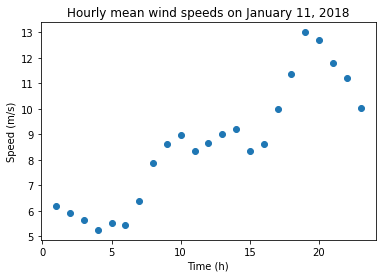

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Time (h)')
ax.set_ylabel('Speed (m/s)')
ax.set_title('Hourly mean wind speeds on January 11, 2018')
line = ax.plot(hours,hourly_mean_speeds,'o')

### Create a mean wind speed wind rose for January 10, 2018
This exercise considers only data from January 10, 2018. First the bad data (represented by '99' or '999' in NDBC data) must be removed. Then we create the wind rose using the `plot_rose` function from the `tidal.graphics` submodule.

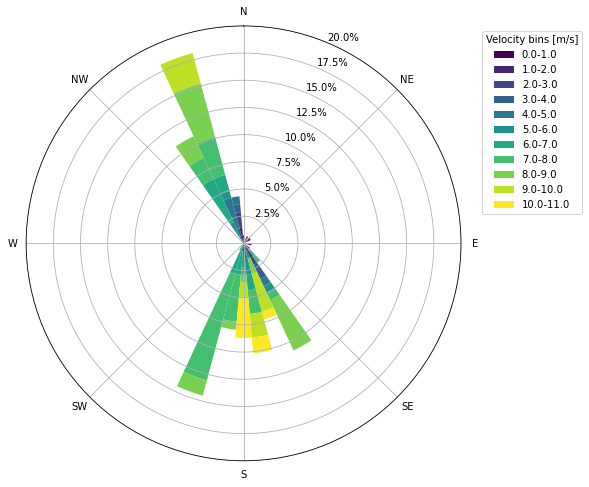

In [9]:
monthly_data = ndbc_data['2018']['2018-01']
daily_data = monthly_data['2018-01-10']

# Remove bad speed data
mean_speed_data = daily_data[daily_data.WDIR < 999]

# Set the rose bin widths
width_direction = 10   # in degrees
width_velocity  = 1 # in m/s

# Plot the wind rose
ax = plot_rose(mean_speed_data.WDIR,mean_speed_data.WSPD,
                     width_direction,width_velocity)

### Create a joint PDF of the wind gusts for January, 2018
An alternative to the wind rose, the joint probability density function can be used to visualize the gust speeds and directions from January, 2018. The gust speed and direction are represented by `GST` and `GDR` respectively. Gust data is provided only hourly for the 'cwind' parameter, whereas continous wind is provided on a 10-minute basis. To be illustrate the joint PDF, we represent all of January here. We will again pull data from the appropriate date and remove any missing data.

c:\users\akeeste\documents\software\github\mhkit-python\mhkit\tidal\graphics.py:265: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks)


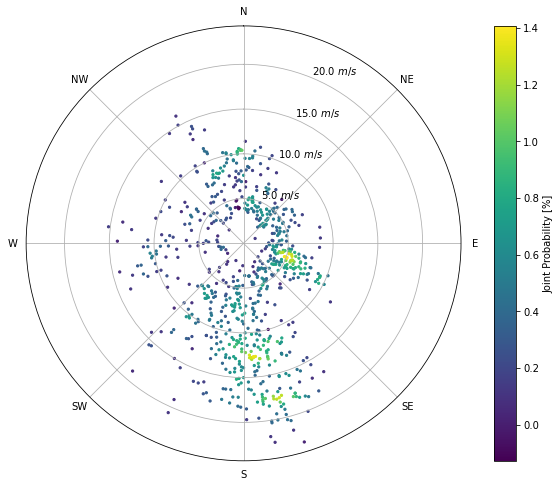

In [10]:
daily_data = monthly_data['2018-01']

# Remove bad gust data
gust_data = daily_data[daily_data.GDR < 999]

# Set the joint probability bin widths
width_direction = 10   # in degrees
width_velocity  = 1 # in m/s

# Plot the joint probability distribution
ax = plot_joint_probability_distribution(gust_data.GDR, gust_data.GST, 
                                         width_direction, width_velocity)